In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("customer_segmentation_data_clean.csv")
df.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
0,3197.0,205.42,0,0,1,0,0,0,0,1,0,0,0
1,63.0,149.99,0,1,0,0,0,1,0,0,0,0,0
2,605.0,119.00,0,0,1,1,0,0,0,0,0,0,0
3,20.0,240.00,0,0,1,0,0,0,0,1,0,0,0
4,245.0,184.36,1,0,0,0,0,0,0,1,0,0,0


# Data Standardization

Prior the hierarchical clustering and k-means, we need to standardize the data. Without it, our results would be unrealible and skewed, specially considering the difference in magnitude regarding minutes watched versus CLV. 

In [3]:
cols_to_std = ["minutes_watched", "clv"]

preprocessor = ColumnTransformer(
    transformers=[
        #('scaler', StandardScaler(), cols_to_std),
        ('scaler', RobustScaler(), cols_to_std),
        ("passthrough", "passthrough", [col for col in df if col not in cols_to_std])
    ]
)
df_scaled = preprocessor.fit_transform(df)
feature_names = preprocessor.get_feature_names_out()
feature_names = [f.split("__")[1] for f in feature_names]
df_scaled = pd.DataFrame(df_scaled, columns=feature_names)

In [4]:
df_scaled.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
0,2.047476,0.988674,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.314243,0.354536,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.094197,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.346647,1.384281,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.177091,0.747741,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Hierarchical clustering

After the data standardization is complete, we can finally utilize clustering the data. Let's start by using the `Ward` method. 

In [5]:
hier_clust = linkage(df_scaled, method='ward')

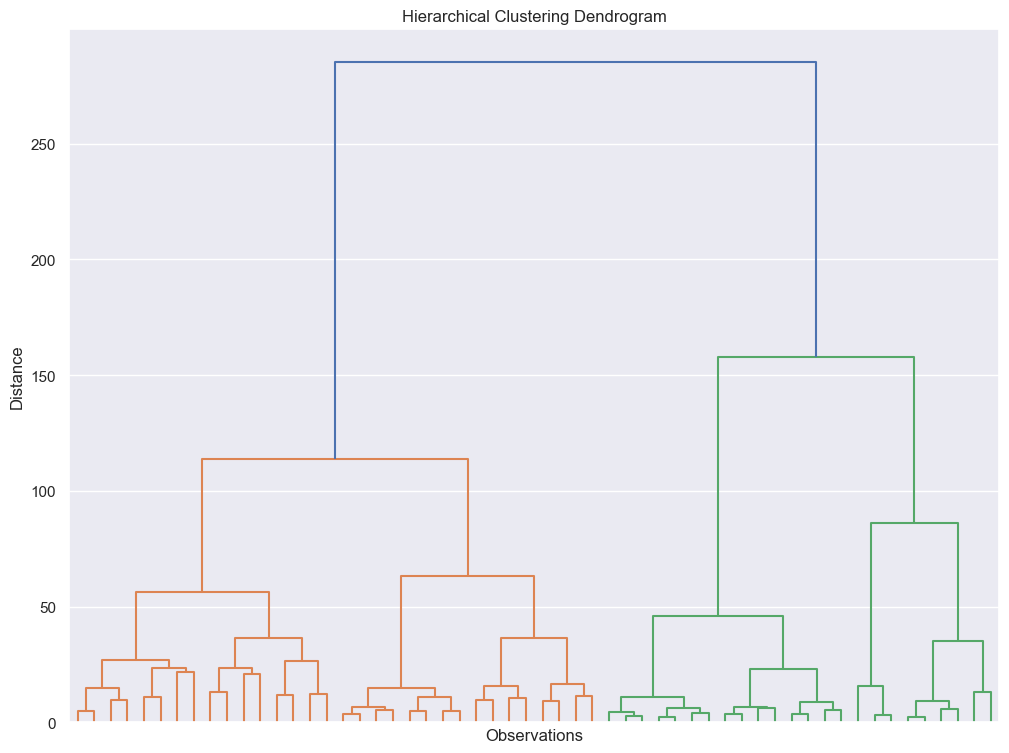

In [6]:
plt.figure(figsize=(12,9))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clust, truncate_mode="level", p=5, show_leaf_counts=False, no_labels=True)
plt.show()

The result of the algorithm points to 4 separate clusters.

# K-Means Clustering

Now let's try with the K-means clustering algorithm, we'll perform an iteration with 10 steps, utilizing k-means++ as the initializer.

In [7]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,
                    init="k-means++",
                    random_state=42)

    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

Plot the results to see if the elbow can be spotted:

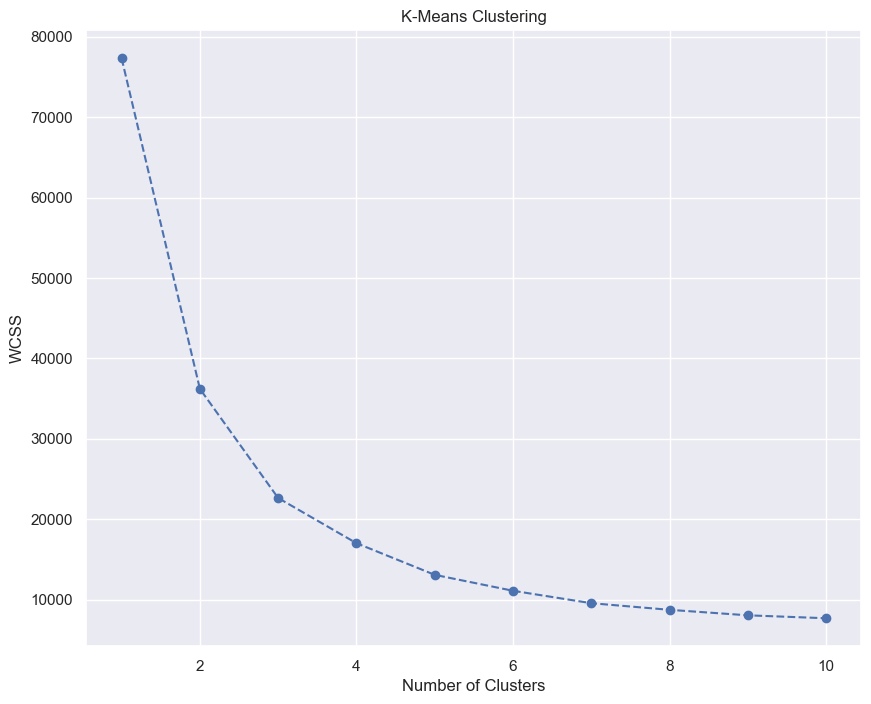

In [8]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("K-Means Clustering")
plt.show()

The elbow is around **k = 3** (or 4). The drop in WCSS is steep from 1 to 3 and then flattens; gains beyond 4 are small.

Since both methods lead to around 4 clusters, this is the number we will use looking forward.

# Model Evaluation

In [10]:
# Creating a copy of the original dataframe to avoid modifying it directly.
df_segmented = df.copy()

# Assigning the cluster labels generated by k-means to a new column named 'Segment' in the copied dataframe.
df_segmented['cluster_labels'] = fcluster(Z=hier_clust, t=4, criterion="maxclust")
df_segmented.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube,cluster_labels
0,3197.0,205.42,0,0,1,0,0,0,0,1,0,0,0,3
1,63.0,149.99,0,1,0,0,0,1,0,0,0,0,0,4
2,605.0,119.00,0,0,1,1,0,0,0,0,0,0,0,2
3,20.0,240.00,0,0,1,0,0,0,0,1,0,0,0,3
4,245.0,184.36,1,0,0,0,0,0,0,1,0,0,0,4


In [ ]:
# Grouping the dataframe by the 'cluster_labels' column and calculating the mean for each segment.
# This provides a profile for each cluster based on the mean values of the original features.
df_segm_analysis = df_segmented.groupby(['cluster_labels']).mean()
df_segm_analysis

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
cluster_labels,,,,,,,,,,,,,
1,30429.810127,190.733797,0.202532,0.265823,0.531646,0.101266,0.113924,0.177215,0.050633,0.088608,0.177215,0.000000,0.291139
2,1489.188406,87.839503,0.001553,0.021739,0.976708,0.089545,0.151139,0.162008,0.074017,0.194099,0.049172,0.028986,0.251035
3,2487.287179,297.823949,0.205128,0.400000,0.394872,0.066667,0.138462,0.235897,0.061538,0.138462,0.051282,0.010256,0.297436
4,793.765212,129.686656,0.247081,0.752919,0.000000,0.068224,0.092194,0.183159,0.079902,0.148125,0.103872,0.000000,0.324524


In [12]:
# Counting the number of observations in each segment.
# This is done by grouping by 'Segment' and counting the occurrences.
# 'region_rest' is used arbitrarily to count, as it exists in each segment.
df_segm_analysis['n'] = df_segmented[['cluster_labels','region_rest']].groupby(['cluster_labels']).count()

# Calculating the proportion of observations in each segment.
# This is done by dividing the number of observations in a segment by the total number of observations.
df_segm_analysis['proportion'] = df_segm_analysis['n'] / df_segm_analysis['n'].sum()
df_segm_analysis

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube,n,proportion
cluster_labels,,,,,,,,,,,,,,,
1,30429.810127,190.733797,0.202532,0.265823,0.531646,0.101266,0.113924,0.177215,0.050633,0.088608,0.177215,0.000000,0.291139,79,0.020610
2,1489.188406,87.839503,0.001553,0.021739,0.976708,0.089545,0.151139,0.162008,0.074017,0.194099,0.049172,0.028986,0.251035,1932,0.504044
3,2487.287179,297.823949,0.205128,0.400000,0.394872,0.066667,0.138462,0.235897,0.061538,0.138462,0.051282,0.010256,0.297436,195,0.050874
4,793.765212,129.686656,0.247081,0.752919,0.000000,0.068224,0.092194,0.183159,0.079902,0.148125,0.103872,0.000000,0.324524,1627,0.424472
